# Analiza sentymentu z wykorzystaniem BERT i zbioru Amazon Reviews

## Czynności przygotowawcze
Parametry:

In [8]:
datasetUrl = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz'
dataPath = './data/reviews.json.gz'

Dane karty graficznej:

In [9]:
!nvidia-smi

Sat May  1 17:35:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.40       Driver Version: 461.40       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:26:00.0  On |                  N/A |
| 28%   33C    P8    21W / 120W |   1083MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Importowane biblioteki:

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os
import transformers
import pandas as pd
import gzip
import wget
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from imblearn.under_sampling import RandomUnderSampler
from ReviewDataset import create_data_loader
from SentimentClassifier import SentimentClassifier
from training import train_epoch, eval_model, show_confusion_matrix, get_predictions

Pobieranie zbioru danych i rozpakowywanie:

In [12]:
try:
    os.stat('./data/')
except:
    os.mkdir('./data/')

try:
    f = open(dataPath)
except IOError:
    print("File not accessible, downloading")
    wget.download(datasetUrl, out=dataPath)
finally:
    if 'f' in locals():
        f.close()

Ładowanie danych:

In [13]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(dataPath)

## Analiza danych:

In [14]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


In [15]:
df.shape

(551682, 9)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551682 entries, 0 to 551681
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      551682 non-null  object 
 1   asin            551682 non-null  object 
 2   reviewerName    546729 non-null  object 
 3   helpful         551682 non-null  object 
 4   reviewText      551682 non-null  object 
 5   overall         551682 non-null  float64
 6   summary         551682 non-null  object 
 7   unixReviewTime  551682 non-null  int64  
 8   reviewTime      551682 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 42.1+ MB


Histogram ilości słów w opinii:

Text(0.5, 0, 'review score')

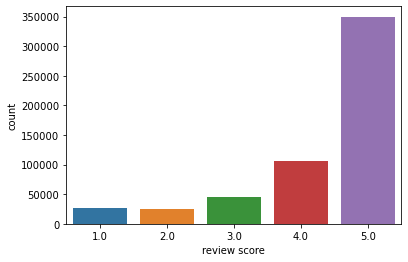

In [17]:
sns.countplot(x='overall', data=df)
plt.xlabel('review score')

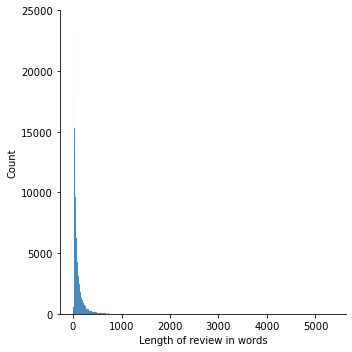

In [18]:
numbers_of_words = df['reviewText'].str.split().str.len()
plot = sns.displot(numbers_of_words, )
plot.set_axis_labels('Length of review in words', 'Count')

Jak widać zbiór jest mocno niezbalansowany, więc istnieje konieczność jego zbalansowania. Ze względu na tekstowy charakter zbioru zastosowanie generującego upsamplingu odpada, iilość danych w zbiorze jest duża, więc undersampling będzie odpowiednim rozwiązaniem.

Przeważająca większość opinii jest krótsza niż 512 słów.

In [19]:
class_names = ['1', '2', '3', '4', '5']
RANDOM_SEED = 1232
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED, stratify=df[['overall']])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, stratify=df_test[['overall']])


undersample = RandomUnderSampler(sampling_strategy='not minority')
df_train_undersample, _ = undersample.fit_resample(df_train, df_train[['overall']])

Podział klas zbioru treningowego:

Text(0.5, 0, 'review score')

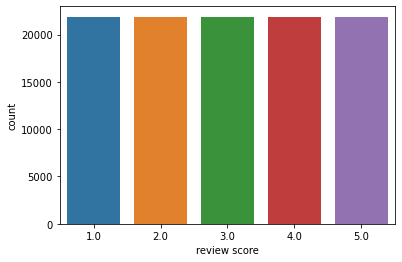

In [20]:
sns.countplot(x='overall',data=df_train_undersample)
plt.xlabel('review score')

Zbiór zostanie podzielony na zbiór testowy i trenujący z zachowaniem propocji klas, hiperparametry modelu będą wyznaczane w procesie strojenia na zbiorze treningowym z wykorzystaniem k-krotnej walidacji krzyżowej. Podczas jednej iteracji k-krotnej walidacji krzyżowej zbiór trenujący będzie poddawany downsamplingowi w celu zbalansowania klas, a zbiór testujący pozostanie bez zmian.

Ogólnie muszę zrobić takie pipeliny jak na zumach. O ile w ogóle jest potrzebne strojenie hiperparametrów, może wystarczy po prostu k-krotna bez wstępnego train test splita.

Jak wynika z analizy, większość słów mieści się w zakresie 0-512 słów, więc ustalenie limitu tokenów BERT na górny próg - 512 będzie wystarczające. Dłuższe opinie zostaną skrócone do długości 512 tokenów.

Przygotowanie do treningu:

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
TOKEN_MAX_LEN = 512
BATCH_SIZE = 16
EPOCHS = 10

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
train_data_loader = create_data_loader(df_train_undersample, tokenizer, TOKEN_MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, TOKEN_MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, TOKEN_MAX_LEN, BATCH_SIZE)

model = SentimentClassifier(len(class_names), PRE_TRAINED_MODEL_NAME)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Trening:

In [25]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 6.00 GiB total capacity; 4.30 GiB already allocated; 45.16 MiB free; 4.34 GiB reserved in total by PyTorch)

## Wyniki treningu

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Ewaluacja na zbiorze testowym:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Macierz błędu:

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=TOKEN_MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')